In [147]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model

In [148]:
# Define Train and Test Datasets
# Define a new extraction path with a different name
extract_path = "/content/drive/MyDrive/Classroom/Artificial_Intelligence/Week-5/"
train_dir = os.path.join(extract_path, "FruitinAmazon/train")
test_dir = os.path.join(extract_path, "FruitinAmazon/test")

In [149]:
class_names = os.listdir(train_dir)
print(f"Classes: {class_names}")

Classes: ['pupunha', 'acai', 'guarana', 'graviola', 'tucuma', 'cupuacu']


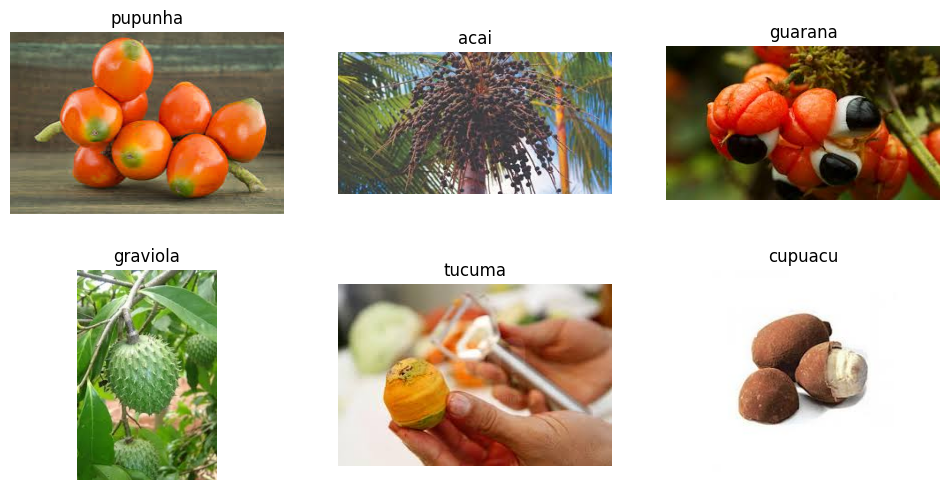

In [150]:
def visualize_images(train_dir, class_names):
    fig, axes = plt.subplots(2, len(class_names) // 2, figsize=(12, 6))
    axes = axes.flatten()
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        img_name = random.choice(os.listdir(class_path))
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path)
        axes[i].imshow(img)
        axes[i].set_title(class_name)
        axes[i].axis("off")
    plt.show()

visualize_images(train_dir, class_names)

In [151]:
damagedImages = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = load_img(img_path)
        except (IOError, SyntaxError):
            damagedImages.append(img_path)
            os.remove(img_path)
            print(f"Damaged image removed: {img_path}")

if not damagedImages:
    print("No Damaged Images Found.")

No Damaged Images Found.


In [152]:
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

In [153]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset='training',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 72 files for training.


In [154]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 90 files belonging to 6 classes.
Using 18 files for validation.


In [155]:
rescale = Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

In [156]:
num_classes = len(class_names)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    MaxPooling2D((2,2), strides=2),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D((2,2), strides=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)                   │ (None, 128, 128, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 64, 64, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,116,454 (8.07 MB)

 Trainable params: 2,116,454 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

In [157]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [158]:
callbacks = [
    ModelCheckpoint("best_model.h5", save_best_only=True, monitor="val_accuracy", mode="max"),
    EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=callbacks
)

Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - accuracy: 0.1551 - loss: 1.8625

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 432ms/step - accuracy: 0.1545 - loss: 1.8778 - val_accuracy: 0.0000e+00 - val_loss: 2.0023
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.2344 - loss: 1.8872

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 353ms/step - accuracy: 0.2383 - loss: 1.8695 - val_accuracy: 0.0556 - val_loss: 1.6567
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.3495 - loss: 1.7111

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 328ms/step - accuracy: 0.3524 - loss: 1.6997 - val_accuracy: 0.1111 - val_loss: 1.7690
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3536 - loss: 1.5560

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.3624 - loss: 1.5474 - val_accuracy: 0.2778 - val_loss: 1.6504
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.5810 - loss: 1.2996

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 349ms/step - accuracy: 0.5747 - loss: 1.3040 - val_accuracy: 0.6667 - val_loss: 1.4389
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 309ms/step - accuracy: 0.6094 - loss: 1.2283 - val_accuracy: 0.3889 - val_loss: 1.4409
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 285ms/step - accuracy: 0.8030 - loss: 0.9416 - val_accuracy: 0.3333 - val_loss: 1.4671
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 308ms/step - accuracy: 0.6840 - loss: 0.8518 - val_accuracy: 0.6667 - val_loss: 0.8700
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9306 - loss: 0.4846

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 325ms/step - accuracy: 0.9271 - loss: 0.4902 - val_accuracy: 0.7778 - val_loss: 0.7263
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 328ms/step - accuracy: 0.8819 - loss: 0.4251 - val_accuracy: 0.7222 - val_loss: 0.5646
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 292ms/step - accuracy: 0.9705 - loss: 0.2616 - val_accuracy: 0.7222 - val_loss: 0.6617
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9497 - loss: 0.2302

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - accuracy: 0.9518 - loss: 0.2245 - val_accuracy: 0.8333 - val_loss: 0.6362
Epoch 13/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9699 - loss: 0.1168

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.9705 - loss: 0.1150 - val_accuracy: 0.9444 - val_loss: 0.3522
Epoch 14/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 469ms/step - accuracy: 1.0000 - loss: 0.0694 - val_accuracy: 0.8333 - val_loss: 0.3313
Epoch 15/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 1.0000 - loss: 0.0346 - val_accuracy: 0.8333 - val_loss: 0.4193
Epoch 16/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 305ms/step - accuracy: 1.0000 - loss: 0.0236 - val_accuracy: 0.8889 - val_loss: 0.3081
Epoch 17/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 306ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.8889 - val_loss: 0.2515
Epoch 18/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 1.0000 - loss: 0.0089 - val_accuracy: 0.8889 - val_loss: 0.2501
Epoch 19/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 0.8889 - val_loss: 0.2167
Epoch 20/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 290ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.8889 - val_lo

In [159]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='int',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

test_ds = test_ds.map(lambda x, y: (rescale(x), y))
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Found 30 files belonging to 6 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.7667 - loss: 0.7615
Test Accuracy: 76.67%


In [160]:
model.save("final_model.h5")
loaded_model = tf.keras.models.load_model("final_model.h5")

In [161]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = loaded_model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
              precision    recall  f1-score   support

     pupunha       0.80      0.80      0.80         5
        acai       0.57      0.80      0.67         5
     guarana       0.83      1.00      0.91         5
    graviola       0.80      0.80      0.80         5
      tucuma       0.80      0.80      0.80         5
     cupuacu       1.00      0.40      0.57         5

    accuracy                           0.77        30
   macro avg       0.80      0.77      0.76        30
weighted avg       0.80      0.77      0.76        30



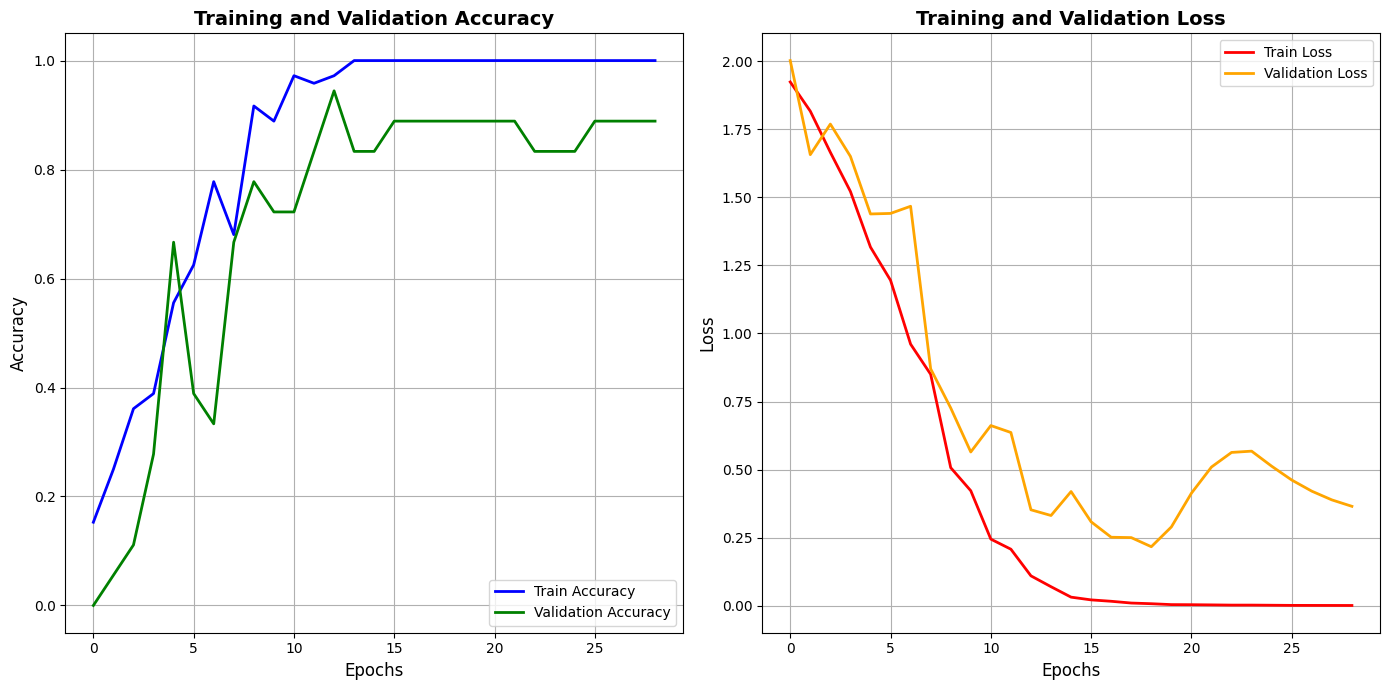

In [162]:
plt.figure(figsize=(14, 7))


plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='lower right', fontsize=10)
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Training and Validation Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

plt.tight_layout()
plt.show()